In [1]:
#import dependencies

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


In [3]:
# Normalize the data
# z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)


In [4]:
# one-hot encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


In [5]:
# build the model

baseNeuronsNum = 32
weight_decay = 1e-4 # l2 regularization hypeparameter

model = Sequential()
model.add(Conv2D(baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*baseNeuronsNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [6]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)


In [7]:
# training
batch_size = 64
epochs=25

from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)



# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# optimizer = keras.optimizers.adam(lr=0.0005,decay=1e-6)

opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs*2,verbose=1,validation_data=(x_test,y_test))
model.save_weights('cifar10_improvement.h5')

Epoch 1/50
781/781 [==============================] - 32s - loss: 2.1217 - acc: 0.3761 - val_loss: 1.4227 - val_acc: 0.5342
Epoch 2/50
781/781 [==============================] - 31s - loss: 1.5013 - acc: 0.5129 - val_loss: 1.2300 - val_acc: 0.6016
Epoch 3/50
781/781 [==============================] - 31s - loss: 1.2911 - acc: 0.5778 - val_loss: 0.9997 - val_acc: 0.6681
Epoch 4/50
781/781 [==============================] - 31s - loss: 1.1525 - acc: 0.6209 - val_loss: 0.8497 - val_acc: 0.7214
Epoch 5/50
781/781 [==============================] - 31s - loss: 1.0557 - acc: 0.6492 - val_loss: 0.8020 - val_acc: 0.7384
Epoch 6/50
781/781 [==============================] - 31s - loss: 0.9839 - acc: 0.6728 - val_loss: 0.7809 - val_acc: 0.7433
Epoch 7/50
781/781 [==============================] - 31s - loss: 0.9363 - acc: 0.6892 - val_loss: 0.6946 - val_acc: 0.7711
Epoch 8/50
781/781 [==============================] - 31s - loss: 0.8867 - acc: 0.7067 - val_loss: 0.7037 - val_acc: 0.7675
Epoch 9/

In [8]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s     

Test result: 87.260 loss: 0.446


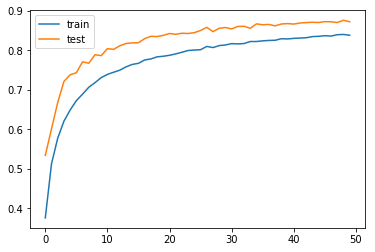

In [9]:
# plot learning curves of model accuracy
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()